In [1]:
import glob
import sys, os
import time, pickle
import re
from ete3 import NCBITaxa
sys.path.append("/Users/chilpert/Work/pyproteinsExt/src")
sys.path.append("/Users/chilpert/Work/pyproteins/src")
import pyproteinsExt.topology as topology
%load_ext autoreload
%autoreload 2

In [2]:
def save(data, tag=None):
    print(data)
    saveDir="/Volumes/arwen/mobi/group/NOX_CH/pickle_saved"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fTag = "NOX_annotation_" + tag + "_" if tag else "NOX_annotation_"
    fSerialDump = fTag + timestr + ".pickle"
    with open(saveDir + '/' + fSerialDump, 'wb') as f:
        pickle.dump(data, f)
    print('data structure saved to', saveDir + '/' + fSerialDump)

def load(fileName):
    saveDir="/Volumes/arwen/mobi/group/NOX_CH/pickle_saved"
    d = pickle.load( open(saveDir + "/" + fileName, "rb" ) )
    print("restore a annotated container of ", len(d), "elements")
    return d

### Raw Pfam domains

First, NOX signature search is done by using Pfam domains corresponding to FAD_binding, NAD_binding and Ferric_reduct

#### Preliminary work 
Starting from complete trEMBL dataset `arwen:/mobi/group/NOX_CH/data/uniprot_trembl.fasta.gz` which is a symbolic link for `arwen:/mobi/group/databases/flat/uniprot_trembl_2019_02.fasta.gz`
 *  Split the dataset in small volumes
     * script: <span style="color:green">**split.py**</span>
     * Usage:
     Create and go to the `/mobi/group/NOX_GH/volumes` 
```console
    ROOT_DIR=/mobi/group/NOX_CH
    SCRIPT_DIR=/mobi/group/NOX_CH/nox-analysis/scripts
    $SCRIPT_DIR/split.py $ROOT_DIR/data/uniprot_trembl.fasta.gz
```

* Run the HMMR and TMHMM annotations
    * script: <span style="color:green">**runHMMR_slurm.sh**</span>
    * Usage:  
  
```console
    mkdir $ROOT_DIR/seedSet
    mkdir $ROOT_DIR/seedSet/work
    $SCRIPT_DIR/runHMMR_slurm.sh $ROOT_DIR/volumes $ROOT_DIR/seedSet/work $ROOT_DIR/data/profiles
```

In [3]:
dataDir=glob.glob('/Volumes/arwen/mobi/group/NOX_CH/seedSet/work/uniprot_trembl_v*')

#### Parse hmmr, tmhmm and fasta

In [4]:
def parsing_results(dataDir):
    dataDir_length=len(dataDir)
    c=1
    print(c,"/",dataDir_length)
    dataContainer=topology.parse(hmmrOut=dataDir[0]+"/hmmsearch.out",tmhmmOut=dataDir[0]+"/tmhmm.out",fastaOut=dataDir[0]+"/hmmsearch.fasta")
    for dir in dataDir[1:]:
        c+=1
        if c%10==0:
            print(c,"/",dataDir_length)
        dataContainer=dataContainer.addParsing(topology.parse(hmmrOut=dir+"/hmmsearch.out",tmhmmOut=dir+"/tmhmm.out",fastaOut=dir+"/hmmsearch.fasta"))
    return dataContainer

In [5]:
dataContainer=parsing_results(dataDir)

1 / 293
10 / 293
20 / 293
30 / 293
40 / 293
50 / 293
60 / 293
70 / 293
80 / 293
90 / 293
100 / 293
110 / 293
120 / 293
130 / 293
140 / 293
150 / 293
160 / 293
170 / 293
180 / 293
190 / 293
200 / 293
210 / 293
220 / 293
230 / 293
240 / 293
250 / 293
260 / 293
   [No individual domains that satisfy reporting thresholds (although complete target did)]


270 / 293
280 / 293
290 / 293


In [6]:
print("Number of proteins :",len(dataContainer))

Number of proteins : 178540


In [7]:
save(dataContainer,"All")

data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_All_20190613-162757.pickle


#### Filter proteins that match the three domains

In [8]:
def filter_three_domains(entry): 
    domains=set([hmm_obj.domain for hmm_obj in entry.hmmr])
    if len(domains)==3:
        return True
    return False

In [9]:
filteredThreeDomains=dataContainer.filter(filter_three_domains)

In [10]:
print('Number of proteins with 3 domains : ',len(filteredThreeDomains))

Number of proteins with 3 domains :  18020


#### Filter helix

* Helix number

In [11]:
def filter_nb_helix(entry,**kwargs):
    min_helix=kwargs["min_helix"]
    max_helix=kwargs["max_helix"]
    if entry.tmhmm.nb_helix>=min_helix and entry.tmhmm.nb_helix<=max_helix:
        return True 
    return False

In [12]:
filteredNbHelix=filteredThreeDomains.filter(filter_nb_helix,min_helix=2,max_helix=7)

In [13]:
print("Number of proteins with 3 domains and between 2 and 7 helix :",len(filteredNbHelix.entries))

Number of proteins with 3 domains and between 2 and 7 helix : 15559


* Bi-histidine 

In [14]:
def filter_bi_histidine(entry):
    seq=entry.fasta.seq
    topo_seq=entry.tmhmm.topology_seq
    H_status = []
    if len(topo_seq)!=len(seq):
        raise Exception("Topology seq and amino acids seq with different size. Check !")
    for i in range(len(seq)):
        if topo_seq[i]=="i" or topo_seq[i]=="o":
            continue
        if not seq[i]=="H":
            continue
        H_status.append( [i, topo_seq[i], False] )     
    for i in range (len(H_status) - 1):
        for j in range (i + 1, len(H_status)):
            if H_status[i][1] != H_status[j][1]:
                continue
            d = H_status[i][0] - H_status[j][0]
            if d >= 12 or d <= 14:
                H_status[i][2] = True
                
    # Only keep marked histidine
    H_status = [ x for x in H_status if x[2] ]
    # Create a dicitinary where keys are Helices numbers
    H_groups = {}
    for x in H_status:
        if not x[2]:
            continue
        if x[1] not in H_groups:
            H_groups[x[1]]=[]
        H_groups[x[1]].append(x)
        
    # The test is passed if at least two distinct helices feature at least one correctly spaced histidine pair
    # ie : if the helice dictionary has more than 1 entrie
    HisTestBool = True if len(H_groups) > 1 else False     
    return HisTestBool

In [15]:
filteredBiHistidine=filteredNbHelix.filter(filter_bi_histidine)

In [16]:
print("Proteins with bi-histidine in helix :",len(filteredBiHistidine))

Proteins with bi-histidine in helix : 5972


#### Filter eukaryotic sequences

* Get taxid for entries

In [17]:
def function_get_taxid(entry):
    reTaxid=re.compile("[.]*OX=([\d]*)")
    taxid=reTaxid.findall(entry.fasta.header)[0]
    return taxid

In [18]:
for e in filteredBiHistidine: 
    e.get_taxo(function_get_taxid)

* Filter

In [19]:
ncbi=NCBITaxa()

In [20]:
def filter_eukaryotic_header(entry):
    try:
        lineage=ncbi.get_lineage(entry.taxo.taxid)
        lineage_rank=ncbi.get_rank(lineage)
        superkingdom=[taxid for taxid in lineage_rank if lineage_rank[taxid]=='superkingdom']
        if superkingdom:
            name=ncbi.get_taxid_translator(superkingdom)[superkingdom[0]]
            if name == "Eukaryota":
                return False
            else:
                return True
        else: 
            return False
    except : 
        return False
        print(taxid,"not found")

In [21]:
filteredEukaryotic=filteredBiHistidine.filter(filter_eukaryotic_header)

In [22]:
print("Non-eukaryotic :", len(filteredEukaryotic))

Non-eukaryotic : 851


In [23]:
save(filteredEukaryotic,"filteredAll")

data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_filteredAll_20190613-163034.pickle


#### Filter evalue

In [24]:
def filter_evalue(entry,**kwargs):
    threshold=kwargs["threshold"]
    conserve=0
    domains=set()
    for h in entry.hmmr: 
        if float(h.hit.iEvalue) <= threshold:
            domains.add(h.domain)
    if len(domains)==3:
        return True
    return False     

In [25]:
def filter_evalue_hit(hit,**kwargs):
    threshold=kwargs["threshold"]
    if float(hit.hit.iEvalue)<=threshold: 
        return True 
    return False

In [26]:
filteredEvalue_3=filteredEukaryotic.filter(filter_evalue,threshold=1e-3).filter_hit(filter_evalue_hit,threshold=1e-3)
filteredEvalue_2=filteredEukaryotic.filter(filter_evalue,threshold=1e-2).filter_hit(filter_evalue_hit,threshold=1e-2)
filteredEvalue_1=filteredEukaryotic.filter(filter_evalue,threshold=1e-1).filter_hit(filter_evalue_hit,threshold=1e-1)
filteredEvalue_4=filteredEukaryotic.filter(filter_evalue,threshold=1e-4).filter_hit(filter_evalue_hit,threshold=1e-4)

In [27]:
save(filteredEvalue_3,"filteredEvalue_3")

data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_filteredEvalue_3_20190613-163051.pickle


In [28]:
dic_evalue={'all':filteredEukaryotic,'1e-1':filteredEvalue_1,'1e-2':filteredEvalue_2,'1e-3':filteredEvalue_3,'1e-4':filteredEvalue_4}

In [29]:
for evalue in dic_evalue: 
    print("Number of proteins",evalue,":",len(dic_evalue[evalue]))

Number of proteins all : 851
Number of proteins 1e-1 : 412
Number of proteins 1e-2 : 311
Number of proteins 1e-3 : 169
Number of proteins 1e-4 : 80


#### Search with regular expressions

In [30]:
def filter_seq_motif(entry,**kwargs):
    motif=kwargs["motif"]
    if motif.search(entry.fasta.seq):
        return True
    return False

In [31]:
NADPH=re.compile("G[ISVL]G[VIAF][TAS][PYTA]")
FAD=re.compile("H[PSA]F[TS][LIMV]")

In [32]:
for evalue in dic_evalue: 
    container=dic_evalue[evalue]
    motifNADPH=container.filter(filter_seq_motif,motif=NADPH)
    motifFAD=container.filter(filter_seq_motif,motif=FAD)
    motifBoth=container.filter(filter_seq_motif,motif=NADPH).filter(filter_seq_motif,motif=FAD)
    print("==",evalue)
    print("NADPH :",len(motifNADPH),"/",len(container),"-",round(len(motifNADPH)/len(container)*100,2),'%')
    print("FAD :",len(motifFAD),"/",len(container),"-",round(len(motifFAD)/len(container)*100,2),'%')
    print("Both :",len(motifBoth),"/",len(container),"-",round(len(motifBoth)/len(container)*100,2),'%')
    print()

== all
NADPH : 677 / 851 - 79.55 %
FAD : 602 / 851 - 70.74 %
Both : 451 / 851 - 53.0 %

== 1e-1
NADPH : 383 / 412 - 92.96 %
FAD : 345 / 412 - 83.74 %
Both : 322 / 412 - 78.16 %

== 1e-2
NADPH : 293 / 311 - 94.21 %
FAD : 261 / 311 - 83.92 %
Both : 245 / 311 - 78.78 %

== 1e-3
NADPH : 165 / 169 - 97.63 %
FAD : 145 / 169 - 85.8 %
Both : 142 / 169 - 84.02 %

== 1e-4
NADPH : 80 / 80 - 100.0 %
FAD : 66 / 80 - 82.5 %
Both : 66 / 80 - 82.5 %



#### Save NOX predicted proteins

In [33]:
mfasta=filteredEvalue_3.proteins_mfasta()
o=open("/Volumes/arwen/mobi/group/NOX_CH/predicted_NOX_proteins_global_profile_1e-3.mfasta",'w')
o.write(mfasta)
o.close()

### Refine Pfam domains

Re-annotate by using new Pfam domains, created with only prokaryote domain sequences

#### Write domain sequences in multifasta, from filtered proteins at 1e-3

In [34]:
mfasta_nad=filteredEvalue_3.get_domain_mfasta("PF08030_full")
mfasta_fad=filteredEvalue_3.get_domain_mfasta("PF08022_full")
mfasta_ferric=filteredEvalue_3.get_domain_mfasta("PF01794_full")

In [35]:
nad_output="/Volumes/arwen/mobi/group/NOX_CH/RefineProfile/nad_binding_proka_1e-3.mfasta"
fad_output="/Volumes/arwen/mobi/group/NOX_CH/RefineProfile/fad_binding_proka_1e-3.mfasta"
ferric_output="/Volumes/arwen/mobi/group/NOX_CH/RefineProfile/ferric_reduct_proka_1e-3.mfasta"

In [36]:
o=open(nad_output,"w")
o.write(mfasta_nad)
o.close()
o=open(fad_output,"w")
o.write(mfasta_fad)
o.close()
o=open(ferric_output,"w")
o.write(mfasta_ferric)
o.close()

#### Create new hmm profiles

```console
WORKDIR=/mobi/group/NOX_CH/RefineProfile
module load clustalw
module load hmmr

cd $WORKDIR 
for p in fad_binding nad_binding ferric_reduct; do 
    clustalw2 -INFILE=$p\_proka_1e-3.mfasta -OUTFILE=$p\_1e-3_multiple_alignment.clustal;
    hmmbuild -n $p\_prokaryotes $p\_prokaryotes.hmm $p\_1e-3_multiple_alignment.clustal;
done
```

### Search NOX proteins with refined pfam domains

* Prepare environment
```console 
WORKDIR=/mobi/group/NOX_CH
mkdir $WORKDIR/data/refined_profiles
cp $WORKDIR/RefineProfile/fad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles/fad_binding.hmm
cp $WORKDIR/RefineProfile/nad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles/nad_binding.hmm
cp $WORKDIR/RefineProfile/ferric_reduct_prokaryotes.hmm $WORKDIR/data/refined_profiles/ferric_reduct.hmm
mkdir $WORKDIR/NOX_refined_profiles
```

* Run hmm and tmhmm
```console
$SCRIPT_DIR/runHMMR_slurm.sh $WORKDIR/volumes $WORKDIR/NOX_refined_profiles $WORKDIR/data/refined_profiles
```

#### Filter proteins

In [37]:
dataDir_refined=glob.glob('/Volumes/arwen/mobi/group/NOX_CH/NOX_refined_profiles/uniprot_trembl_v*')

In [38]:
dataContainer_refined=parsing_results(dataDir_refined)

1 / 293
10 / 293
20 / 293
30 / 293
40 / 293
50 / 293
60 / 293
70 / 293
80 / 293
90 / 293
100 / 293
110 / 293
120 / 293
130 / 293
140 / 293
150 / 293
160 / 293
170 / 293
180 / 293
190 / 293
200 / 293
210 / 293
220 / 293
   [No individual domains that satisfy reporting thresholds (although complete target did)]


230 / 293
240 / 293
250 / 293
260 / 293
270 / 293
280 / 293
290 / 293


In [39]:
print("Number of proteins :",len(dataContainer_refined))

Number of proteins : 190820


In [40]:
save(dataContainer_refined,"refined_All")

data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_refined_All_20190613-164854.pickle


In [41]:
#3 domains 
filterThreeDomains_refined=dataContainer_refined.filter(filter_three_domains)
print("Number of proteins with 3 domains : ",len(filterThreeDomains_refined))

# Helix filter
filterHelix_refined=filterThreeDomains_refined.filter(filter_nb_helix,min_helix=2,max_helix=7).filter(filter_bi_histidine)
print("Number of proteins after helix filter : ",len(filterHelix_refined))

# Eukaryotic filter 
for e in filterHelix_refined: 
    e.get_taxo(function_get_taxid)
filterNoEukaryotic_refined=filterHelix_refined.filter(filter_eukaryotic_header)
print("Number of non-eukaryotic proteins :",len(filterNoEukaryotic_refined))

#Evalue 1e-3 filter 
filterEvalue3_refined=filterNoEukaryotic_refined.filter(filter_evalue,threshold=1e-3).filter_hit(filter_evalue_hit,threshold=1e-3)
print("Number of non-eukaryotic proteins after evalue 1e-3 filter :",len(filterEvalue3_refined))

Number of proteins with 3 domains :  14483
Number of proteins after helix filter :  5057
Number of non-eukaryotic proteins : 990
Number of non-eukaryotic proteins after evalue 1e-3 filter : 946


In [49]:
save(filterNoEukaryotic_refined,"refined_filterAll")
save(filterEvalue3_refined,"refined_filter1e-3")

data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_refined_filterAll_20190613-165505.pickle
data structure saved to /Volumes/arwen/mobi/group/NOX_CH/pickle_saved/NOX_annotation_refined_filter1e-3_20190613-165507.pickle


#### Save predicted proteins

In [42]:
mfasta=filterEvalue3_refined.proteins_mfasta()
o=open("/Volumes/arwen/mobi/group/NOX_CH/predicted_NOX_proteins_refined_profile_1e-3.mfasta",'w')
o.write(mfasta)
o.close()

#### Check regular expressions

In [43]:
motifNADPH=filterEvalue3_refined.filter(filter_seq_motif,motif=NADPH)
motifFAD=filterEvalue3_refined.filter(filter_seq_motif,motif=FAD)
motifBoth=filterEvalue3_refined.filter(filter_seq_motif,motif=NADPH).filter(filter_seq_motif,motif=FAD)
print("NADPH :",len(motifNADPH),"/",len(filterEvalue3_refined),"-",round(len(motifNADPH)/len(filterEvalue3_refined)*100,2),'%')
print("FAD :",len(motifFAD),"/",len(filterEvalue3_refined),"-",round(len(motifFAD)/len(filterEvalue3_refined)*100,2),'%')
print("Both :",len(motifBoth),"/",len(filterEvalue3_refined),"-",round(len(motifBoth)/len(filterEvalue3_refined)*100,2),'%')

NADPH : 745 / 946 - 78.75 %
FAD : 678 / 946 - 71.67 %
Both : 507 / 946 - 53.59 %


### Compare before and after refined profiles

In [10]:
filterEvalue3=load("NOX_annotation_filteredEvalue_3_20190613-163051.pickle")
filterEvalue3_refined=load("NOX_annotation_refined_filter1e-3_20190613-165507.pickle")

restore a annotated container of  169 elements
restore a annotated container of  946 elements


In [11]:
proteins_before=set([p.split("|")[1] for p in filterEvalue3.entries])
proteins_after=set([p.split("|")[1] for p in filterEvalue3_refined.entries])

In [12]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

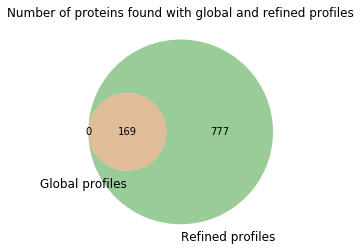

In [16]:
v=venn2([proteins_before,proteins_after])
v.get_label_by_id("A").set_text("Global profiles")
v.get_label_by_id("B").set_text("Refined profiles")
plt.title("Number of proteins found with global and refined profiles")
plt.savefig("/Users/chilpert/Work/NOX_visu_new/nb_prot_before_after_refined_profiles.pdf")

All proteins found with global profiles are also found with refined profiles and we have 777 more proteins with refined profiles

### Proteins distribution in taxonomy

In [25]:
import subprocess

In [26]:
o=open("/Volumes/arwen/mobi/group/NOX_CH/Taxonomy/proteins_taxonomy_taxid_krona.tsv","w")
o.write("#protein\ttaxid\tscore\n")
for e in filterEvalue3_refined : 
    o.write(e.prot+"\t"+e.taxo.taxid+"\t1\n")
o.close()

In [27]:
#Run kronaTools
subprocess.run(['ktImportTaxonomy','/Volumes/arwen/mobi/group/NOX_CH/Taxonomy/proteins_taxonomy_taxid_krona.tsv','-o','/Users/chilpert/Work/NOX_visu_new/taxo_krona_filtered.html'])

CompletedProcess(args=['ktImportTaxonomy', '/Volumes/arwen/mobi/group/NOX_CH/Taxonomy/proteins_taxonomy_taxid_krona.tsv', '-o', '/Users/chilpert/Work/NOX_visu_new/taxo_krona_filtered.html'], returncode=0)

### Re-refined proteins

In [ ]:
mfasta_nad=filterEvalue3_refined.get_domain_mfasta("nad_binding_prokaryotes")
mfasta_fad=filterEvalue3_refined.get_domain_mfasta("fad_binding_prokaryotes")
mfasta_ferric=filterEvalue3_refined.get_domain_mfasta("ferric_reduct_prokaryotes")

In [ ]:
nad_output="/Volumes/arwen/mobi/group/NOX_CH/ReRefineProfile/nad_binding_proka_1e-3.mfasta"
fad_output="/Volumes/arwen/mobi/group/NOX_CH/ReRefineProfile/fad_binding_proka_1e-3.mfasta"
ferric_output="/Volumes/arwen/mobi/group/NOX_CH/ReRefineProfile/ferric_reduct_proka_1e-3.mfasta"

In [ ]:
o=open(nad_output,"w")
o.write(mfasta_nad)
o.close()
o=open(fad_output,"w")
o.write(mfasta_fad)
o.close()
o=open(ferric_output,"w")
o.write(mfasta_ferric)
o.close()

```console
WORKDIR=/mobi/group/NOX_CH/ReRefineProfile
module load clustalw
module load hmmr

cd $WORKDIR 
for p in fad_binding nad_binding ferric_reduct; do 
    clustalw2 -INFILE=$p\_proka_1e-3.mfasta -OUTFILE=$p\_1e-3_multiple_alignment.clustal;
    hmmbuild -n $p\_prokaryotes $p\_prokaryotes.hmm $p\_1e-3_multiple_alignment.clustal;
done
```


* Prepare environment
```console 
WORKDIR=/mobi/group/NOX_CH
mkdir $WORKDIR/data/re_refined_profiles
cp $WORKDIR/ReRefineProfile/fad_binding_prokaryotes.hmm $WORKDIR/data/re_refined_profiles/fad_binding.hmm
cp $WORKDIR/ReRefineProfile/nad_binding_prokaryotes.hmm $WORKDIR/data/re_refined_profiles/nad_binding.hmm
cp $WORKDIR/ReRefineProfile/ferric_reduct_prokaryotes.hmm $WORKDIR/data/re_refined_profiles/ferric_reduct.hmm
mkdir $WORKDIR/NOX_re_refined_profiles
```

* Run hmm and tmhmm
```console
$SCRIPT_DIR/runHMMR_slurm.sh $WORKDIR/volumes $WORKDIR/NOX_re_refined_profiles $WORKDIR/data/re_refined_profiles
```

In [ ]:
dataDir_re_refined=glob.glob('/Volumes/arwen/mobi/group/NOX_CH/NOX_re_refined_profiles/uniprot_trembl_v*')

In [ ]:
dataContainer_re_refined=parsing_results(dataDir_re_refined)

In [ ]:
#3 domains 
filterThreeDomains_re_refined=dataContainer_re_refined.filter(filter_three_domains)
print("Number of proteins with 3 domains : ",len(filterThreeDomains_re_refined))

# Helix filter
filterHelix_re_refined=filterThreeDomains_re_refined.filter(filter_nb_helix,min_helix=2,max_helix=7).filter(filter_bi_histidine)
print("Number of proteins after helix filter : ",len(filterHelix_re_refined))

# Eukaryotic filter 
filterNoEukaryotic_re_refined=filterHelix_re_refined.filter(filter_eukaryotic_header)
print("Number of non-eukaryotic proteins :",len(filterNoEukaryotic_re_refined))

#Evalue 1e-3 filter 
filterEvalue3_re_refined=filterNoEukaryotic_re_refined.filter(filter_evalue,threshold=1e-3).filter_hit(filter_evalue_hit,threshold=1e-3)
print("Number of non-eukaryotic proteins after evalue 1e-3 filter :",len(filterEvalue3_re_refined))

### Test refined profiles with evalue 1e-1

In [ ]:
filteredEvalue_1=load("NOX_annotation_filtered1e-1_20190524-143321.pickle")

#### Write domain sequences

In [ ]:
mfasta_nad=filteredEvalue_1.get_domain_mfasta("PF08030_full",1e-1)
mfasta_fad=filteredEvalue_1.get_domain_mfasta("PF08022_full",1e-1)
mfasta_ferric=filteredEvalue_1.get_domain_mfasta("PF01794_full",1e-1)

In [ ]:
nad_output="/Volumes/arwen/mobi/group/NOX_CH/RefineProfile/nad_binding_proka_1e-1.mfasta"
fad_output="/Volumes/arwen/mobi/group/NOX_CH/RefineProfile/fad_binding_proka_1e-1.mfasta"
ferric_output="/Volumes/arwen/mobi/group/NOX_CH/RefineProfile/ferric_reduct_proka_1e-1.mfasta"

In [ ]:
o=open(nad_output,"w")
o.write(mfasta_nad)
o.close()
o=open(fad_output,"w")
o.write(mfasta_fad)
o.close()
o=open(ferric_output,"w")
o.write(mfasta_ferric)
o.close()

#### Create new hmm profiles

```console
WORKDIR=/mobi/group/NOX_CH/RefineProfile
module load clustalw
module load hmmr

cd $WORKDIR 
for p in fad_binding nad_binding ferric_reduct; do 
    clustalw2 -INFILE=$p\_proka_1e-1.mfasta -OUTFILE=$p\_1e-1_multiple_alignment.clustal;
    hmmbuild -n $p\_prokaryotes $p\_1e-1_prokaryotes.hmm $p\_1e-1_multiple_alignment.clustal;
done
```

#### Relaunch NOX proteins search

```console
WORKDIR=/mobi/group/NOX_CH
mkdir $WORKDIR/data/refined_profiles_1e-1
cp $WORKDIR/RefineProfile/fad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles_1e-1/fad_binding.hmm
cp $WORKDIR/RefineProfile/nad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles_1e-1/nad_binding.hmm
cp $WORKDIR/RefineProfile/ferric_reduct_prokaryotes.hmm $WORKDIR/data/refined_profiles_1e-1/ferric_reduct.hmm
mkdir $WORKDIR/NOX_refined_profiles_1e-1

$SCRIPT_DIR/runHMMR_slurm.sh $WORKDIR/volumes $WORKDIR/NOX_refined_profiles_1e-1 $WORKDIR/data/refined_profiles_1e-1
```

#### Filter proteins

In [ ]:
dataDir_refined1=glob.glob('/Volumes/arwen/mobi/group/NOX_CH/NOX_refined_profiles_1e-1/uniprot_trembl_v*')

In [ ]:
dataContainer_refined1=parsing_results(dataDir_refined1)

In [ ]:
print("Number of proteins :",len(dataContainer_refined1))

In [ ]:
save(dataContainer_refined1,"refined_1e-1_All")

In [ ]:
#3 domains 
filterThreeDomains_refined1=dataContainer_refined1.filter(filter_three_domains)
print("Number of proteins with 3 domains : ",len(filterThreeDomains_refined1))

# Helix filter
filterHelix_refined1=filterThreeDomains_refined1.filter(filter_nb_helix,min_helix=2,max_helix=7).filter(filter_bi_histidine)
print("Number of proteins after helix filter : ",len(filterHelix_refined1))

# Eukaryotic filter 
filterNoEukaryotic_refined1=filterHelix_refined1.filter(filter_eukaryotic_header)
print("Number of non-eukaryotic proteins :",len(filterNoEukaryotic_refined1))

#Evalue 1e-3 filter 
filterEvalue3_refined1=filterNoEukaryotic_refined1.filter(filter_evalue,threshold=1e-3)
print("Number of non-eukaryotic proteins after evalue 1e-3 filter :",len(filterEvalue3_refined1))

In [ ]:
new_proteins=set([p.split("|")[1] for p in filterEvalue3_refined1.entries])

In [ ]:
if not new_proteins.difference(proteins_after):
    print("No difference between refined profiles with domains 1e-3 and with domains 1e-1")
else: 
    print("Difference between refined profiles with domains 1e-3 and with domains 1e-1. Need to check.")